# Deep Neural Networks: Libraries comparison

## I) Network:
L-layers neural network for binary and multi-class classifications

### Activation functions
- **ReLU**: $A = RELU(Z) = max(0, Z)$
- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$

### Cost Function
- **Cross-Entropy Loss**: $ \frac{1}{m}\sum^m_{i=1} y^{(i)}*log(\hat y^{[L](i)}) + (1-y^{(i)})*log(1- \hat y^{[L](i)})$

### Optimizer 
- **Mini-Batch Gradient Descent**
- $ W^{\{k\}[l]} = W^{\{k\}[l]} - \alpha * dW^{\{k\}[l]}$
- $ b^{\{k\}[l]} = b^{\{k\}[l]} - \alpha * db^{\{k\}[l]}$


## II) Datasets
- **Cat vs Non Cat classification**
    - a training set of 209 images labelled as cat (1) or non-cat (0)
    - a test set of 50 labelled as cat and non-cat
    - each image is of shape (64, 64, 3) where 3 is for the 3 channels (RGB).


- **MNIST Dataset for multi-class**
    - a training set of 14.000 images labelled as cat (1) or non-cat (0)
    - a test set of 1.400 labelled as cat and non-cat
    - each image is of shape (28, 28, 1)

In [48]:
from functions_NN import *; from utili_np import *
import numpy as np; import pandas as pd; import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

Binary Dataset: Cat vs Non Cat Classification


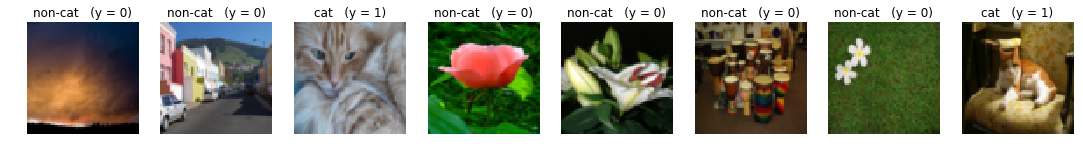

Multi-Class Dataset: MNIST


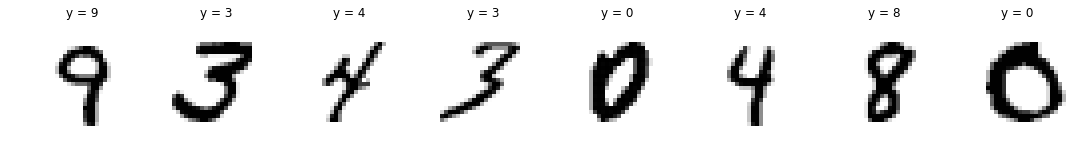

In [49]:
dataset_show(num_images = 8)

In [50]:
# Controller

# A) Dataset Selection: 1 for "Binary Cat dataset"     2 for "MNIST Dataset"
dataset = 2
n_train = 3000
n_test = 300

#B) NN architecture
L1 = 30
L2 = 20
hidden_layers = [L1, L2] #Number of units in the hidden layers

# C) Hyperparameter selection
alpha = 0.05
n_epochs = 1000

#%% 1) Image loading and Parameters Initialization

#Image loading
if dataset == 1:
    X_train, Y_train, X_test, Y_test, classes = load_cats_dataset()

if dataset == 2:
    X_train, Y_train, X_test, Y_test, classes = load_MNIST_dataset(n_train, n_test)
    
m = X_train.shape[1]
nx = X_train.shape[0]
ny = Y_train.shape[0]

## 1) Numpy implementation

Cost after iteration 0: 6.966069
Cost after iteration 100: 1.934036
Cost after iteration 200: 1.149946
Cost after iteration 300: 0.856402
Cost after iteration 400: 0.693138
Cost after iteration 500: 0.592102
Cost after iteration 600: 0.519926
Cost after iteration 700: 0.463651
Cost after iteration 800: 0.417757
Cost after iteration 900: 0.378415

 This is a 3 layers neural network


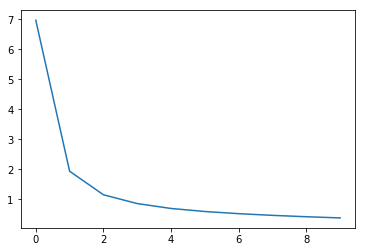

time: 43 seconds
Training Accuracy: 0.960333333333
Test Accuracy: 0.903333333333
Mislabelled examples


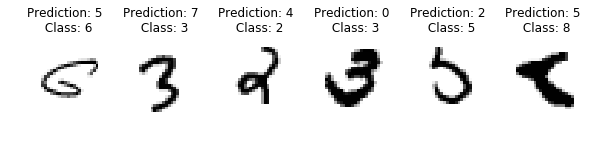

In [54]:
#Parameters Initialization
params = initialize_params(nx, ny, hidden_layers, existing = "No")

#%% 2) Neural Network Training

costs = [] #Save cost at every iteration to print
start = time.time()

for i in range(n_epochs):
    
    #Forward Propagation
    A, caches = forward_prop(X_train, params)
    
    #Cost Function
    cost = compute_cost(A, Y_train)
    
    #Backward propagation
    grads = backward_prop(A, Y_train, caches)
    
    #Update parameters
    params = update_params(params, grads, alpha)
    
    #Print Cost every 100 iterations
    if i % 100 == 0: 
        print("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
        
end = time.time()
print("time: " + str(int(end-start))+" seconds \n")
print("\n %i layers neural network" %(len(hidden_layers)+1))
plt.figure(2)
plt.plot(np.squeeze(costs))
plt.show()

#%% 3) Evaluate Performancies

#Calculate Accuracies
P_train, acc_train = predict(X_train, Y_train, params)
print("Training Accuracy: "+str(acc_train))
P_test, acc_test = predict(X_test, Y_test, params)
print("Test Accuracy: "+str(acc_test))
print("\n")
print("Mislabelled examples")

#Printing Mislabeled Examples
printing_mislabeled_images(X_test, Y_test, P_test, classes, num_images = 6)

## 2) TensorFlow implementation

In [75]:
import tensorflow as tf
def tf_create_placeholders(nx, ny):
    with tf.name_scope('input'):
        X = tf.placeholder(shape = [nx, None], dtype = "float", name = "X")
        Y = tf.placeholder(shape = [ny, None], dtype = "float", name = "Y")
        prob = tf.placeholder_with_default(1.0, shape=())
    return X,Y, prob

def tf_initialize_parameters_FC(nx, hidden_layers, ny):
#for key, nh in layers_dims.items()
    layer_dims = []
    layer_dims.append(nx)
    for i in range(len(hidden_layers)):
        layer_dims.append(hidden_layers[i])
    layer_dims.append(ny)
    assert(len(layer_dims) == len(hidden_layers)+2)

    params = {}
    L = len(layer_dims)
    for l in range(1,L):
        params["W"+str(l)] = tf.get_variable("W"+str(l),[layer_dims[l], layer_dims[l-1]],
                                                         initializer = tf.contrib.layers.xavier_initializer())
        params["b"+str(l)] = tf.get_variable("b"+str(l), [layer_dims[l], 1], initializer = tf.zeros_initializer())

    return params


def tf_forward_prop(X, params,prob):
    Z1 = tf.add(tf.matmul(params['W1'], X), params['b1'])
    A1 = tf.nn.relu(Z1)
    A1 = tf.nn.dropout(A1, prob)
    Z2 = tf.add(tf.matmul(params['W2'], A1), params['b2'])
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(params['W3'], A2), params['b3'])
    return Z3

def tf_compute_cost(Z,Y):
    Z = tf.transpose(Z)
    Y = tf.transpose(Y) #To compute cost I need batch size a first dimension
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits = Z, labels = Y, name = 'Cost'))
    return cost

In [76]:
mb_size = 64
dropout_prob = 1.0 # no dropout

start = time.time()
# Parameters training
tf.reset_default_graph()
X, Y, prob = tf_create_placeholders_FC(nx, C)
params = tf_initialize_parameters_FC(nx, hidden_layers, ny)
Z3 = tf_forward_prop(X, params, prob)
cost = tf_compute_cost(Z3, Y)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = alpha).minimize(cost)
costs = []
num_minibatches = m//mb_size
init = tf.global_variables_initializer()
with tf.Session().as_default() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    # (tensorboard --logdir="./graphs")
    ep_cost = 0
    for epoch in range(n_epochs):
        _, ep_cost = sess.run([optimizer, cost],feed_dict = {X:X_train, Y:Y_train, prob:dropout_prob})
       
        if epoch % 100 == 0:
            print("Cost after epoch %i : %f" %(epoch, ep_cost))
            costs.append(ep_cost)
            
end = time.time() 
print("time: " + str(int(end-start))+" seconds \n")
print("\n %i layers neural network" %(len(hidden_layers)+1))
plt.figure(2)
plt.plot(np.squeeze(costs))
plt.show()

with sess.as_default():   
    correct_prediction =  tf.equal(tf.argmax(Z3), tf.argmax(Y))   
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Training Accuracy", accuracy.eval({X:X_train, Y:Y_train}))
    print("Test Accuracy", accuracy.eval({X:X_test, Y:Y_test}))

    trained_params = sess.run(params) #it returns numpy array


Cost after epoch 0 : 2.366088
Cost after epoch 100 : 0.719100
Cost after epoch 200 : 0.442757


KeyboardInterrupt: 

In [65]:
with sess.as_default():  
    correct_prediction =  tf.equal(tf.argmax(Z3), tf.argmax(Y))   
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Training Accuracy", accuracy.eval({X:X_train, Y:Y_train}))
    print("Test Accuracy", accuracy.eval({X:X_test, Y:Y_test}))

    trained_params = sess.run(params) #it returns numpy array

Training Accuracy 0.966333
Test Accuracy 0.893333


In [74]:
params["W1"].shape

TensorShape([Dimension(30), Dimension(1)])

In [24]:
type(dropout_prob)

int